In [1]:
%matplotlib inline

In [90]:
import fitsio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from astropy import units as u
from astropy.coordinates import SkyCoord

In [15]:
kic = pd.read_csv("data/kic_tgas.csv")
len(kic)

12294

In [27]:
epic = pd.read_csv("data/epic_tgas.csv")
len(epic)

/Users/dfm/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2683: DtypeWarning: Columns (3,82) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


23565

In [19]:
stars = pd.read_csv("data/lr5/t1-1-star.txt")
len(stars)

14290

In [108]:
best_kic = pd.merge(stars, kic, on="tgas_source_id", how="inner")
len(best_kic)

38

In [124]:
with open("data/targets-top.list", "w") as f:
    for _, row in best_kic.iterrows():
        c = SkyCoord(ra=row.ra_x*u.degree, dec=row.dec_x*u.degree)
        s = c.to_string("hmsdms").replace("d", " ").replace("h", " ").replace("m", " ").replace("s", " ")
        s = "k{0} ".format(row.kepid) + s + " 2000\n"
        f.write(s)

In [28]:
joined_epic = pd.merge(stars, epic, on="tgas_source_id", how="inner")
len(joined_epic)

475

In [41]:
stacked_tgas = pd.DataFrame.from_records(fitsio.read("data/stacked_tgas.fits").byteswap().newbyteorder())
stacked_tgas["row_index"] = stacked_tgas.index
pair_indices = pd.DataFrame.from_records(fitsio.read("data/pairindices_cp1.fits").byteswap().newbyteorder())

In [46]:
star1 = pd.merge(pair_indices, stacked_tgas, left_on="star1", right_on="row_index")
star2 = pd.merge(pair_indices, stacked_tgas, left_on="star2", right_on="row_index")

In [63]:
ids = np.unique(np.append(star1.row_index, star2.row_index))
all_stars = stacked_tgas.loc[ids]

In [64]:
joined_kic = pd.merge(all_stars, kic, left_on="source_id", right_on="tgas_source_id", how="inner")
len(joined_kic)

2058

In [78]:
result = pair_indices.groupby("star1").min()
result["star1"] = result.index
result["sep_1"] = result.sep
result["delta_v_1"] = result.delta_v
joined_plus = pd.merge(joined_kic, result[["star1", "sep_1", "delta_v_1"]], left_on="row_index", right_on="star1",
                       how="left")

result = pair_indices.groupby("star2").min()
result["star2"] = result.index
result["sep_2"] = result.sep
result["delta_v_2"] = result.delta_v
joined_plus = pd.merge(joined_plus, result[["star2", "sep_2", "delta_v_2"]], left_on="row_index", right_on="star2",
                       how="left")

joined_plus["sep"] = joined_plus[["sep_1", "sep_2"]].min(axis=1)
joined_plus["delta_v"] = joined_plus[["delta_v_1", "delta_v_2"]].min(axis=1)

In [125]:
skip = set(best_kic.kepid)

m = joined_plus.sep <= 10.0
print(m.sum())
with open("data/targets-small-sep.list", "w") as f:
    for _, row in joined_plus[m].sort_values("sep").iterrows():
        if row.kepid in skip:
            continue
        c = SkyCoord(ra=row.ra_x*u.degree, dec=row.dec_x*u.degree)
        s = c.to_string("hmsdms").replace("d", " ").replace("h", " ").replace("m", " ").replace("s", " ")
        s = "k{0} ".format(row.kepid) + s + " 2000\n"
        f.write(s)
        
m = (joined_plus.sep > 10.0) & (joined_plus.sep < 15.0)
print(m.sum())
with open("data/targets-large-sep.list", "w") as f:
    for _, row in joined_plus[m].sort_values("sep").iterrows():
        if row.kepid in skip:
            continue
        c = SkyCoord(ra=row.ra_x*u.degree, dec=row.dec_x*u.degree)
        s = c.to_string("hmsdms").replace("d", " ").replace("h", " ").replace("m", " ").replace("s", " ")
        s = "k{0} ".format(row.kepid) + s + " 2000\n"
        f.write(s)

401
1211


In [128]:
m = (joined_plus.sep > 10.0) & (joined_plus.sep < 15.0)
print(m.sum())

632


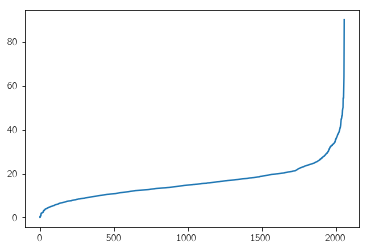

In [123]:
plt.plot(np.arange(len(joined_plus)), joined_plus.sort_values("sep").sep)

In [129]:
best_kic

,row_id,tgas_source_id,name,ra_x,dec_x,parallax,distance,G,J,rave_obs_id,...,tgas_phot_g_n_obs,tgas_phot_g_mean_flux,tgas_phot_g_mean_flux_error,tgas_phot_g_mean_mag,tgas_phot_variable_flag,tgas_l,tgas_b,tgas_ecl_lon,tgas_ecl_lat,tgas_match_distance
0,549,2078226338282711808,TYC 3147-1825-1,293.314346,43.565999,5.4497,185.944,11.960,10.824,NaN,...,150,2.666506e+05,74.511802,11.959914,b'NOT_AVAILABLE',76.310613,11.375660,310.449659,63.767366,0.000030
1,719,2129336071144927360,TYC 3547-1118-1,291.762458,48.586724,7.5043,133.892,9.480,8.517,NaN,...,102,2.617317e+06,3727.590687,9.480129,b'NOT_AVAILABLE',80.469759,14.528299,312.748014,68.818980,0.000028
2,984,2130309173295871232,TYC 3542-2012-1,287.520209,45.911988,7.5257,133.490,8.777,7.921,NaN,...,137,5.001405e+06,4466.351499,8.777040,b'NOT_AVAILABLE',76.733048,16.093481,302.959946,67.356969,0.000027
3,1252,2053228666547587968,HIP 96201,293.430061,39.727916,6.9855,151.835,7.821,7.400,NaN,...,50,1.205922e+07,20362.558491,7.821472,b'NOT_AVAILABLE',72.877288,9.547966,307.873588,60.123686,0.000034
4,1653,2133138697749540352,TYC 3554-119-1,289.444087,50.929356,15.3564,65.304,11.634,9.771,NaN,...,139,3.599005e+05,315.295791,11.634314,b'NOT_AVAILABLE',82.075115,16.839321,311.581936,71.571048,0.000006
5,1703,2133338499628660352,TYC 3554-50-1,288.666410,50.982424,3.5112,292.606,12.013,11.073,NaN,...,114,2.540380e+05,69.087825,12.012523,b'NOT_AVAILABLE',81.932523,17.312830,310.231517,71.821937,0.000029
6,2006,2134742507260532096,TYC 3561-997-1,295.875819,48.592768,10.4177,96.313,8.582,7.580,NaN,...,84,5.986503e+06,5063.583961,8.581837,b'NOT_AVAILABLE',81.706305,12.088411,319.372514,67.646062,0.000019
7,2045,2134875273287557248,TYC 3565-106-1,295.925976,49.444598,9.6817,103.723,9.375,8.245,NaN,...,112,2.883813e+06,8084.875184,9.374852,b'NOT_AVAILABLE',82.495334,12.452075,320.506850,68.385270,0.000016
8,2081,2077179019094164224,TYC 3144-1980-1,296.379929,42.515487,6.1316,164.889,9.967,9.128,NaN,...,112,1.671685e+06,2472.785337,9.966884,b'NOT_AVAILABLE',76.429023,8.904034,314.178509,61.968878,0.000009
9,2106,2135070436600332288,TYC 3564-1127-1,294.000319,49.691331,2.9962,343.523,9.189,8.528,NaN,...,111,3.422567e+06,1457.921199,9.188890,b'NOT_AVAILABLE',82.145447,13.678579,317.765258,69.183169,0.000024
